In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image
from datetime import date

from tqdm import tqdm
import os 

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]
N_year = len(Years)

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
N_year

10

In [56]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)
Levs = [100, 75, 65, 55, 40, 30]
Heights = [16, 18, 19, 20, 22, 24]
# [100, 75, 55, 40, 30]


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs) # 16, 18, 20, 22, 24 km

Lats_edge, Lons_edge, Lats_mid, Lons_mid, N_lat, N_lon, Lons_edge[-1]

(array([-90, -84, -78, -72, -66, -60, -54, -48, -42, -36, -30, -24, -18,
        -12,  -6,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,
         66,  72,  78,  84,  90]),
 array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180]),
 array([-87, -81, -75, -69, -63, -57, -51, -45, -39, -33, -27, -21, -15,
         -9,  -3,   3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,
         69,  75,  81,  87]),
 array([-175, -165, -155, -145, -135, -125, -115, -105,  -95,  -85,  -75,
         -65,  -55,  -45,  -35,  -25,  -15,   -5,    5,   15,   25,   35,
          45,   55,   65,   75,   85,   95,  105,  115,  125,  135,  145,
         155,  165,  175]),
 30,
 36,
 180)

In [5]:
# count the particle (injected at different height) number in each grid cell
N_day = 20*366
Num_2D = np.zeros((N_lat, N_lon, N_lev, N_day)) 


In [6]:
for i_year in tqdm(range(N_year)):
    File = open('./Num_Concnt/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')
    Lines = File.readlines()
    

    NUMs = np.zeros((N_lon*N_lat*N_day, N_lev))
    
    ii = 0
    for line in Lines:
        a = line.split(',')
        NUMs[ii,0] = float(a[3])
        NUMs[ii,1] = float(a[4])
        NUMs[ii,2] = float(a[5])
        NUMs[ii,3] = float(a[6])
        NUMs[ii,4] = float(a[7])
        NUMs[ii,5] = float(a[8])
        ii = ii+1
    

    Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 
    for i_day in range(N_day):
        for ix in range(N_lon):
            for iy in range(N_lat):
                ii = i_day*(N_lat*N_lon) + ix*N_lat + iy
                Num_2D_temp[iy, ix, :, i_day] = NUMs[ii,:]
               
            
    Num_2D = Num_2D + Num_2D_temp            
    
print(ii)
    

100%|██████████| 10/10 [05:16<00:00, 31.68s/it]

7905599


# *** important check ***

(1) The lat dimension should start from 20 and end at -20 for the input data in the following plotting code!!!

(2) The lon dimension should start from -180 and end at 180 for the input data in the following plotting code!!!

In [7]:
# change (-20,20) to (20,-20)

print("LAT Before: ", Lats_mid)

if Lats_mid[0]<Lats_mid[-1]:
    Lats_edge = Lats_edge[::-1]
    Lats_mid = Lats_mid[::-1]
    Num_2D[:, :, :, :] = Num_2D[::-1, :, :, :]

print("LAT After: ", Lats_mid)


LAT Before:  [-87 -81 -75 -69 -63 -57 -51 -45 -39 -33 -27 -21 -15  -9  -3   3   9  15
  21  27  33  39  45  51  57  63  69  75  81  87]
LAT After:  [ 87  81  75  69  63  57  51  45  39  33  27  21  15   9   3  -3  -9 -15
 -21 -27 -33 -39 -45 -51 -57 -63 -69 -75 -81 -87]


In [8]:
Num_2D_new = Num_2D

# fake data, extend 3 years to 9 years by repeating

# # fake 2003-2005 based on 2000-2002
# Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 

# f_date = date(2000, 1, 1)
# l_date = date(2003, 1, 1)
# Delta  = l_date - f_date
# i_day  = Delta.days
# Num_2D_temp[:,:,:,i_day:N_day] = Num_2D_new[:,:,:,0:N_day-i_day]
# Num_2D_new = Num_2D_new + Num_2D_temp


# # fake 2006-2008 based on 2000-2002
# Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 

# f_date = date(2000, 1, 1)
# l_date = date(2006, 1, 1)
# Delta  = l_date - f_date
# i_day  = Delta.days
# Num_2D_temp[:,:,:,i_day:N_day] = Num_2D[:,:,:,0:N_day-i_day]
# Num_2D_new = Num_2D_new + Num_2D_temp


In [9]:
Num_2D_new.shape

(30, 36, 6, 7320)

In [10]:
# monthly data
# To simplify, assume all months have 30 days

N_month = 20*12

Num_2D_month = np.zeros((N_lat, N_lon, N_lev, N_month))

for i_mon in range(N_month):
    Num_2D_month[:,:,:,i_mon] = np.mean(Num_2D_new[:,:,:,i_mon*30:(i_mon+1)*30], axis=3)


In [11]:
# Seasonal data
# begnin with Spring (2000.3-2000.5)

N_season = 20*4-2

Num_2D_season = np.zeros((N_lat, N_lon, N_lev, N_season))

for i_season in range(N_season):
    Num_2D_season[:,:,:,i_season] = np.mean(Num_2D_season[:,:,:,2+i_season*3:2+(i_season+1)*3], axis=3)

/n/home12/hongwei/.conda/envs/SUNenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home12/hongwei/.conda/envs/SUNenv/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [12]:
# annual data

N_year = 20

Num_2D_year = np.zeros((N_lat, N_lon, N_lev, N_year))

for i_yr in range(N_year):
    Num_2D_year[:,:,:,i_yr] = np.mean(Num_2D_new[:,:,:,i_yr*365:(i_yr+1)*365], axis=3)

In [13]:
Num_2D_year.shape

(30, 36, 6, 20)

623169.0 62316.9 60895.0


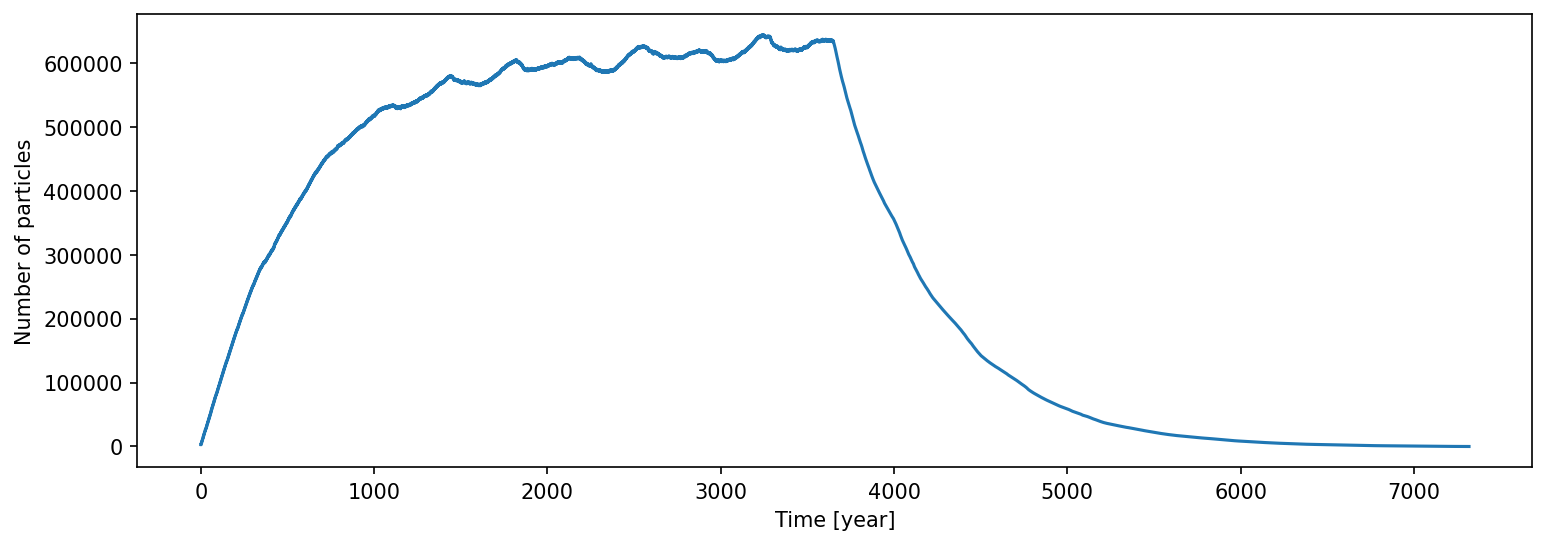

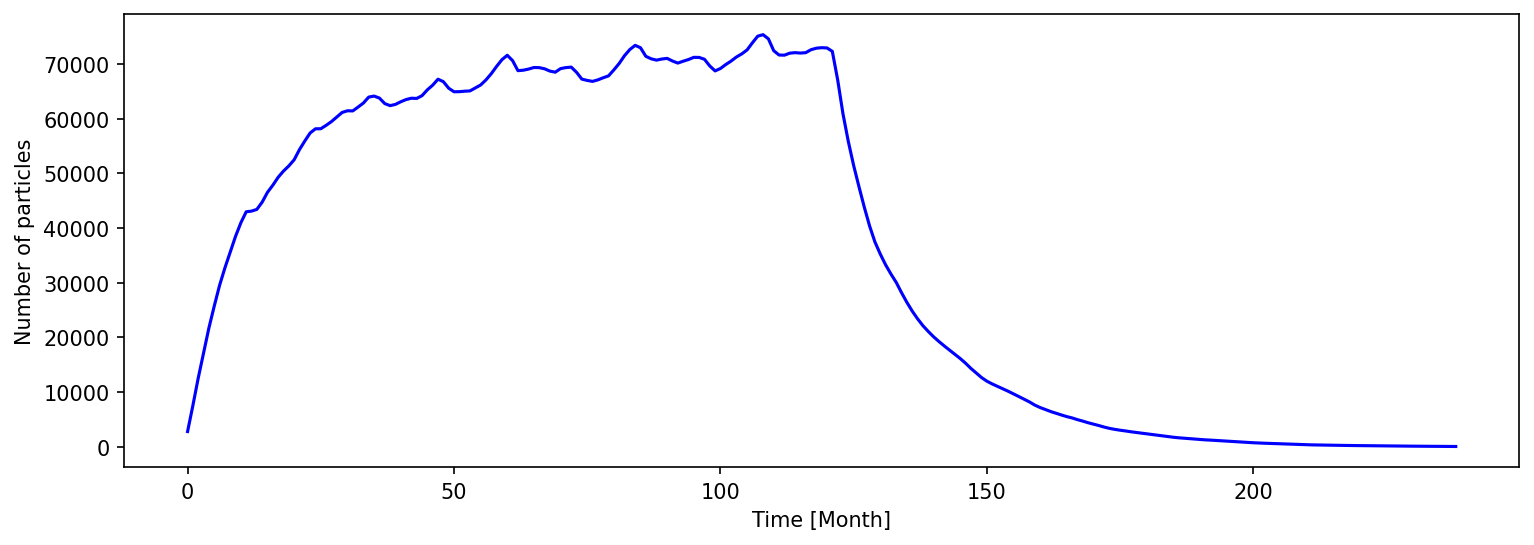

In [74]:
total_num = np.sum( Num_2D_new, axis=(0,1) )
total_num.shape

iz = 1

#
fig = plt.figure(figsize=(12,4), dpi=150)

iday_begin = 0
iday_end = -1

number = np.sum(total_num[:,iday_begin:iday_end], axis=0)
plt.plot( number )
plt.xlabel("Time [year]")
plt.ylabel("Number of particles")

print(number[366*10], number[366*10]*0.1, number[int(366*13.6)])

### monthly
total_num_month = np.sum( Num_2D_month, axis=(0,1) )
total_num_month.shape

fig = plt.figure(figsize=(12,4), dpi=150)

imon_begin = 0
imon_end = -1

plt.plot(total_num_month[iz,imon_begin:imon_end], 'b-')

plt.xlabel("Time [Month]")
plt.ylabel("Number of particles");

# Ymax = 150000
# Ymin = 0
# plt.ylim(Ymin,Ymax)

# plt.plot([6*12,6*12], [Ymin,Ymax], 'r--')
# plt.plot([9*12,9*12], [Ymin,Ymax], 'r--')


# ### yearly
# total_num_year = np.sum( Num_2D_year, axis=(0,1) )
# total_num_year.shape

# fig = plt.figure(figsize=(12,4), dpi=150)

# iyr_begin = 0
# iyr_end = -1

# plt.plot(total_num_year[iz,iyr_begin:iyr_end], 'b-')

# plt.xlabel("Time [year]")
# plt.ylabel("Number of particles");

# Ymax = 150000
# Ymin = 0
# plt.ylim(Ymin,Ymax)

# # plt.plot([6*12,6*12], [Ymin,Ymax], 'r--')
# # plt.plot([9*12,9*12], [Ymin,Ymax], 'r--')

## fit a decay function

$ N(t)=A \cdot e^{-kt} + \sigma $

$\sigma$ is a very small value

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

#### popt array
Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.

#### pcov 2-D array
The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

((3659,), (3659,), 623169.0)

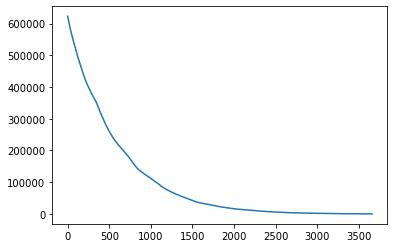

In [64]:
from scipy.optimize import curve_fit

iday_begin = 366*10
iday_end = -1

Ydata = np.sum(total_num[:,iday_begin:iday_end], axis=0)

Xdata = np.arange(len(Ydata))

plt.plot(Xdata,Ydata)

Ydata.shape, Xdata.shape, Ydata[0]


In [16]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [65]:

popt, pcov = curve_fit(func, Xdata, Ydata, bounds=([Ydata[0]-1,-1e10,-0.1], [Ydata[0]+1, 1e10, 0.1]))
popt


array([ 6.23168000e+05,  1.74543404e-03, -1.00000000e-01])

In [18]:

popt, pcov = curve_fit(func, Xdata, Ydata)
popt

<ipython-input-16-c679b9906de7>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-16-c679b9906de7>:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


array([ 6.18854761e+05,  1.70039636e-03, -3.04871486e+03])

In [19]:
Y_fit = func(Xdata, *popt)

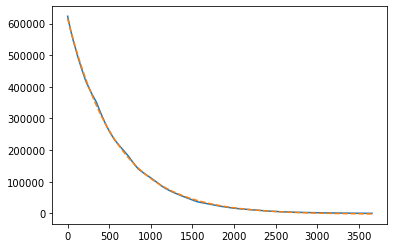

In [20]:
plt.plot(Xdata, Ydata)
plt.plot(Xdata, Y_fit, '--')

## fit the first half data:
$ N(t)=A \cdot e^{-kt} + R \cdot t + \sigma $

In [21]:
# Nx = 24
# Ny = 21
# Nz = 6
# N_parcel = Nx*Ny*Nz
# R = N_parcel

In [22]:
# Y_fit2 = Y_fit + R*Xdata

In [23]:
# plt.plot(Xdata, Ydata)
# plt.plot(Xdata, Y_fit, '--')

(6, 240)


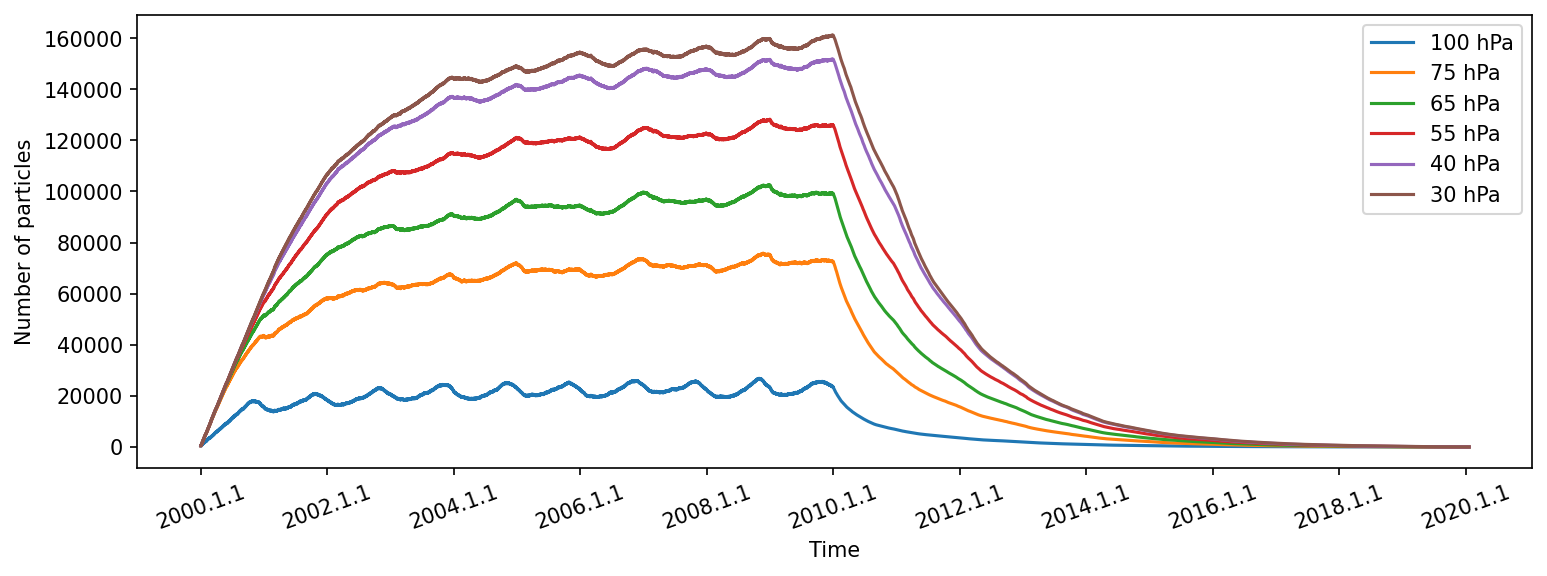

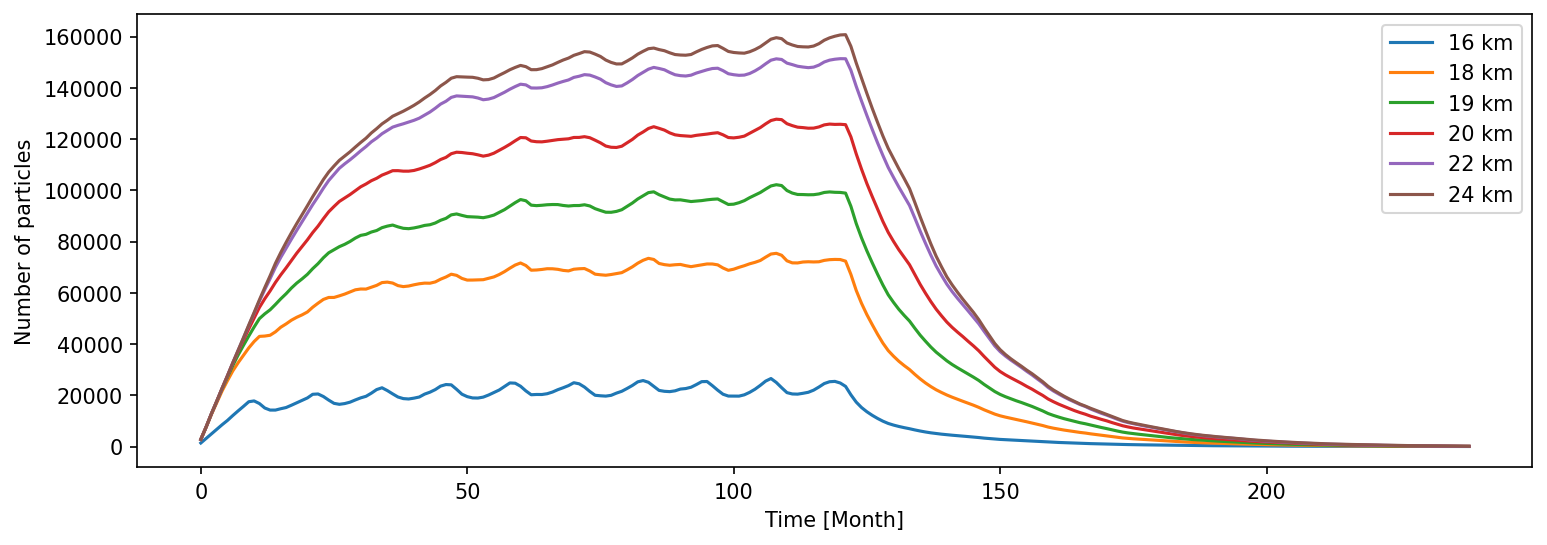

In [57]:
# plot the time series of the total particle number

total_num = np.sum( Num_2D_new, axis=(0,1) )
total_num.shape

#
fig = plt.figure(figsize=(12,4), dpi=150)

iday_begin = 0
iday_end = -1

plt.plot(total_num[0,iday_begin:iday_end], label=f"{Levs[0]} hPa")
plt.plot(total_num[1,iday_begin:iday_end], label=f"{Levs[1]} hPa")
plt.plot(total_num[2,iday_begin:iday_end], label=f"{Levs[2]} hPa")
plt.plot(total_num[3,iday_begin:iday_end], label=f"{Levs[3]} hPa")
plt.plot(total_num[4,iday_begin:iday_end], label=f"{Levs[4]} hPa")
plt.plot(total_num[5,iday_begin:iday_end], label=f"{Levs[5]} hPa")

# plt.xscale("log")
# plt.yscale("log")

# Set text labels and properties.
plt.xticks(np.arange(0,20*365+1,2*365), 
       ['2000.1.1', '2002.1.1', '2004.1.1', '2006.1.1', '2008.1.1', '2010.1.1', \
        '2012.1.1', '2014.1.1', '2016.1.1', '2018.1.1', '2020.1.1'], rotation=20)  

plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.legend();


#------------------------------------------------------------------
# plot the time series of the total particle number

total_num_month = np.sum( Num_2D_month, axis=(0,1) )
print(total_num_month.shape)

#
fig = plt.figure(figsize=(12,4), dpi=150)

imon_begin = 0
imon_end = -1

plt.plot(total_num_month[0,iday_begin:iday_end], label=f"{Heights[0]} km")
plt.plot(total_num_month[1,iday_begin:iday_end], label=f"{Heights[1]} km")
plt.plot(total_num_month[2,iday_begin:iday_end], label=f"{Heights[2]} km")
plt.plot(total_num_month[3,iday_begin:iday_end], label=f"{Heights[3]} km")
plt.plot(total_num_month[4,iday_begin:iday_end], label=f"{Heights[4]} km")
plt.plot(total_num_month[5,iday_begin:iday_end], label=f"{Heights[5]} km")

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Time [Month]")
plt.ylabel("Number of particles")


plt.legend();

### final figure: two sub-plots

Fig.a: total number of injected particles in the stratosphere

Fig.b: number of injected particles at different injection altitude

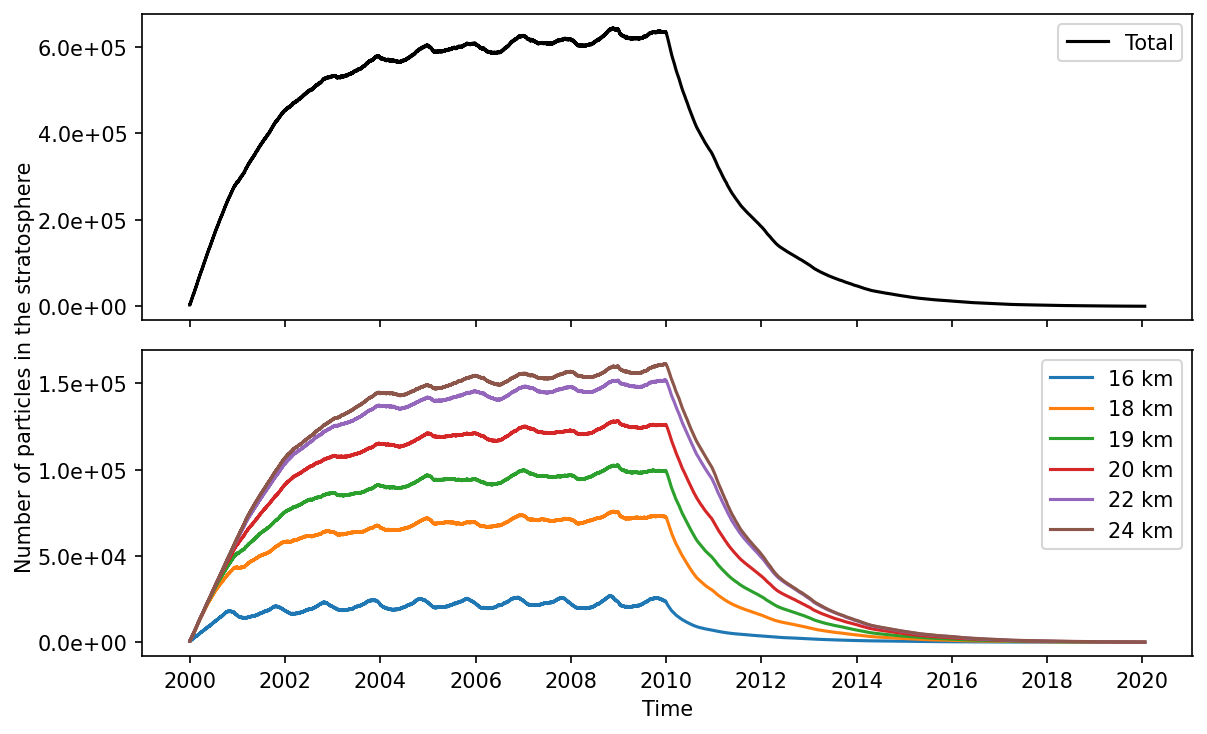

In [63]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, axs = plt.subplots(2, figsize=(8, 5), sharex=True, dpi=150)
# fig.suptitle('Sharing both axes')

# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')

iday_begin = 0
iday_end = -1

###
axs[0].plot( np.sum(total_num[:,iday_begin:iday_end], axis=0), 'k-', label="Total" )

axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
axs[0].legend();

###
axs[1].plot(total_num[0,iday_begin:iday_end], label=f"{Heights[0]} km")
axs[1].plot(total_num[1,iday_begin:iday_end], label=f"{Heights[1]} km")
axs[1].plot(total_num[2,iday_begin:iday_end], label=f"{Heights[2]} km")
axs[1].plot(total_num[3,iday_begin:iday_end], label=f"{Heights[3]} km")
axs[1].plot(total_num[4,iday_begin:iday_end], label=f"{Heights[4]} km")
axs[1].plot(total_num[5,iday_begin:iday_end], label=f"{Heights[5]} km")

axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
axs[1].legend();
# plt.xscale("log")
# plt.yscale("log")

# Set text labels and properties.
plt.xticks(np.arange(0,20*365+1,2*365), 
       ['2000', '2002', '2004', '2006', '2008', '2010', \
        '2012', '2014', '2016', '2018', '2020'], rotation=0) 
# plt.xticks(np.arange(0,20*365+1,2*365), 
#        ['2000.1.1', '2002.1.1', '2004.1.1', '2006.1.1', '2008.1.1', '2010.1.1', \
#         '2012.1.1', '2014.1.1', '2016.1.1', '2018.1.1', '2020.1.1'], rotation=20)  

plt.xlabel("Time")
fig.text(0.0, 0.5, 'Number of particles in the stratosphere', va='center', rotation='vertical')

# plt.ylabel("Number of particles")

plt.tight_layout()

In [35]:
np.arange(0,10*365,365).shape

(10,)

(30, 36)


Text(0.5, 1.0, 'Zonal mean of particle number')

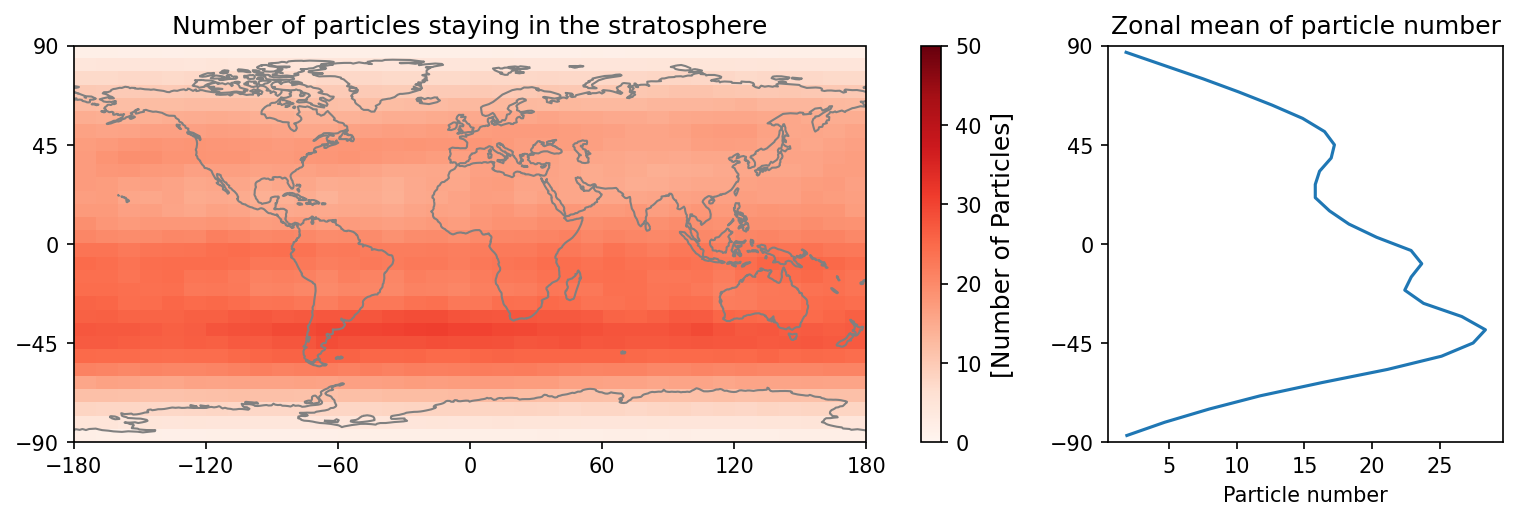

In [36]:
iz = 0
i_day1 = 400
i_day2 = 1000

fig = plt.figure(figsize=(13,3.5), dpi=150)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()

Num_min = 0
Num_max = 50
extent = [-180 , 180 , -90 , 90]

###
ax1 = fig.add_subplot(gs[0, 0:8], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, -90, 90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

# print(Num_2D_new[0:10,0,0,0])

data = np.mean(Num_2D_new[:,:,iz,i_day1:i_day2], axis=2)
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[Number of Particles]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("Number of particles staying in the stratosphere");

print(data.shape)

###
ax2 = fig.add_subplot(gs[0, 8:11])
data2 = np.mean(data, axis=1)

ax2.plot(data2, Lats_mid[:])

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel("Particle number");
ax2.set_title("Zonal mean of particle number")



Add a zonal mena line with for seasonal lines:

Annual mean, Winter mean, Spring mean, Summer mean, Autumn mean

(30, 36)


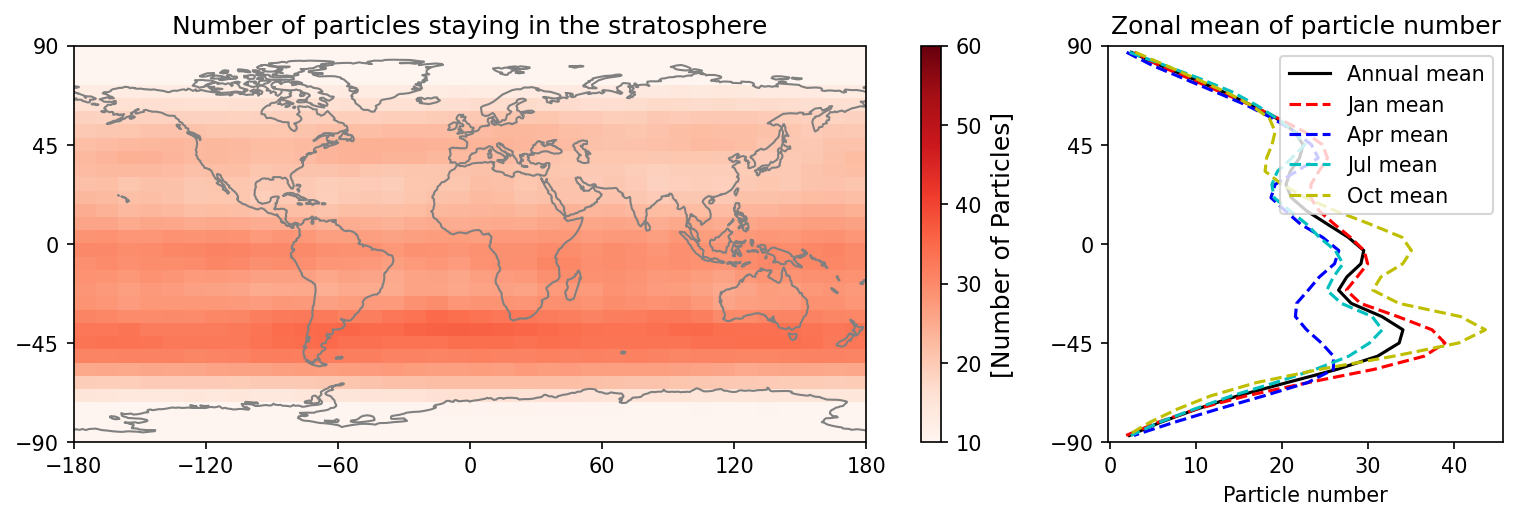

In [37]:
iz = 0
i_mon1 = 6*12
i_mon2 = 9*12

fig = plt.figure(figsize=(13,3.5), dpi=150)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()

Num_min = 10
Num_max = 60
extent = [-180 , 180 , -90 , 90]

###
ax1 = fig.add_subplot(gs[0, 0:8], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, -90, 90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data = np.mean(Num_2D_month[:,:,iz,i_mon1:i_mon2], axis=2)
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[Number of Particles]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("Number of particles staying in the stratosphere");

print(data.shape)


###
ax2 = fig.add_subplot(gs[0, 8:11])

data_all = np.mean(Num_2D_month[:,:,iz,i_mon1:i_mon2], axis=(1,2))
data_Jan = np.mean(Num_2D_month[:,:,iz,i_mon1:i_mon2:12], axis=(1,2))
data_Apr = np.mean(Num_2D_month[:,:,iz,i_mon1+3:i_mon2:12], axis=(1,2))
data_Jul = np.mean(Num_2D_month[:,:,iz,i_mon1+6:i_mon2:12], axis=(1,2))
data_Oct = np.mean(Num_2D_month[:,:,iz,i_mon1+9:i_mon2:12], axis=(1,2))

ax2.plot(data_all[:], Lats_mid, 'k-', label="Annual mean")
ax2.plot(data_Jan[:], Lats_mid, 'r--', label="Jan mean")
ax2.plot(data_Apr[:], Lats_mid, 'b--', label="Apr mean")
ax2.plot(data_Jul[:], Lats_mid, 'c--', label="Jul mean")
ax2.plot(data_Oct[:], Lats_mid, 'y--', label="Oct mean")

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel("Particle number");
ax2.set_title("Zonal mean of particle number");

ax2.legend();